In [1]:
import pandas
pandas.set_option('max_colwidth', 200)

In [2]:
from corus import load_lenta
path = 'data/lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество'
)

In [3]:
#preprocessing: lower-case, commas, lemmatization
#PRACTICE: implement preprocessing

In [4]:
import razdel
from pymystem3 import Mystem
#from pymorphy2 import MorphAnalyzer

_LEMMATIZER = None
def tag(word):
    global _LEMMATIZER
    if _LEMMATIZER is None:
        _LEMMATIZER = Mystem()
        #_LEMMATIZER = MorphAnalyzer('ru')
    try:
        processed = _LEMMATIZER.analyze(word)[0]
    except:
        return word
    if not processed.get('analysis'):
        return word.strip().lower()
    lemma = processed["analysis"][0]["lex"].lower().strip()
    return lemma

import re
def tokenize_re(doc):
    return [tag(x) for x in re.split('(\W+)', doc) if x.strip()]

def tokenize(doc):
    # упомянуть регулярные выражения
    return [tag(t.text) for t in razdel.tokenize(doc)]

import sentencepiece
def tokenize_bpe(doc):
    #FIXME
    pass

print(tokenize_re('Выплаты на второго ребёнка'))
print(tokenize('Выплаты на второго ребёнка'))

['выплата', 'на', 'второй', 'ребенок']
['выплата', 'на', 'второй', 'ребенок']


In [5]:
import pandas
from tqdm import tqdm_notebook as tq

records = load_lenta(path)
# overfitting and underfitting
# splitting the dataset. how many examples to take for a test?
dataset = []
for i, r in tq(enumerate(records), total=25000):
    if not r.topic:
        # есть примеры в датасете, где нет категории
        continue
    dataset.append((tokenize(r.title), r.topic))
    if len(dataset) >= 25000:
        break
df = pandas.DataFrame(dataset, columns=['title', 'class'])
print(len(df))
df.head(5)

25000


,title,class
0,"[называть, регион, россия, с, самый, высокий, смертность, от, рак]",Россия
1,"[австрия, не, представлять, доказательство, вина, российский, биатлонист]",Спорт
2,"[обнаруживать, самый, счастливый, место, на, планета]",Путешествия
3,"[в, сша, раскрывать, сумма, расход, на, расследование, «, российский, дело, »]",Мир
4,"[хакер, рассказывать, о, план, великобритания, заминировать, севастополь]",Мир


In [6]:
classes = sorted(set([_[1] for _ in dataset]))
y_size = len(classes)
print(y_size)
vec_y = {c: i for i, c in enumerate(classes)}
vec_y

17


{'69-я параллель': 0,
 'Бизнес': 1,
 'Бывший СССР': 2,
 'Дом': 3,
 'Из жизни': 4,
 'Интернет и СМИ': 5,
 'Крым': 6,
 'Культпросвет ': 7,
 'Культура': 8,
 'Мир': 9,
 'Наука и техника': 10,
 'Путешествия': 11,
 'Россия': 12,
 'Силовые структуры': 13,
 'Спорт': 14,
 'Ценности': 15,
 'Экономика': 16}

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vec_x = CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x, lowercase=False, min_df=2, binary=False)
vec_x.fit_transform(X_train)
x_size = len(vec_x.get_feature_names())
import pprint; pprint.pprint(vec_x.get_feature_names()[::x_size//10])
print("Vocabulary size:", x_size)

['!',
 'бомбить',
 'гризли',
 'игнашевич',
 'линчевать',
 'ничья',
 'пломбир',
 'пропадать',
 'скульптура',
 'ударный',
 'ярошенко']
Vocabulary size: 8499


In [30]:
vec_x_ids = {v:k for k,v in enumerate(vec_x.get_feature_names())}
print(list(vec_x_ids.items())[:5])

[('!', 0), ('&', 1), ("'", 2), ('+', 3), (',', 4)]


In [31]:
#train, dev, test
#20000, 2500, 2500 
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split([_[0] for _ in dataset], 
                                                  [_[1] for _ in dataset], test_size=2500, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, test_size=2500, random_state=42)
print(len(X_train), len(y_train), len(X_dev), len(y_dev), len(X_test), len(y_test))
display(pandas.DataFrame(zip(X_train[:5], y_train[:5]), columns=['x_train', 'y_train']))
display(pandas.DataFrame(zip(X_dev[:5], y_dev[:5]), columns=['x_dev', 'y_dev']))

20000 20000 2500 2500 2500 2500


,x_train,y_train
0,"[в, россия, закрывать, чемпионат, мир, по, футбол]",Спорт
1,"[назначать, орешкин, неизвестный, таджик, обретать, миссия]",Экономика
2,"[в, киев, массово, лопнуть, труба, после, подача, горячий, вода]",Бывший СССР
3,"[россиянин, избегать, тюрьма, за, убийство, оскорблять, он, девушка]",Россия
4,"[умирать, режиссер, «, чегемский, детектив, », александр, светлов]",Культура


,x_dev,y_dev
0,"[телеведущая, отказывать, в, работа, из-за, «, недостаточно, большой, грудь, »]",Интернет и СМИ
1,"[шарапов, отвечать, на, отказ, серена, уильямс, играть, против, она]",Спорт
2,"[bvlgari, представлять, новый, вариация, на, змеиный, тема]",Ценности
3,"[находить, новый, способ, побеждать, особо, опасный, рак]",Наука и техника
4,"[анестезиолог, изнасиловать, россиянка, под, наркоз, и, пойти, под, суд]",Силовые структуры


In [120]:
from tqdm import tqdm_notebook as tq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device = torch.device('cpu')
params = {
    'batch_size': 2,
    'shuffle': True,
    'num_workers': 0}
eval_params = {
    'batch_size': 64,
    'shuffle': False,
    'num_workers': 0}

In [121]:
class WordsDataset(Dataset):
    def __init__(self, x, y, vec_x_ids, vec_y):
        self.x = x
        self.y = y
        self.vec_x_ids = vec_x_ids 
        self.vec_y = vec_y

    def __getitem__(self, index):
        x_list = [self.vec_x_ids[w] for w in self.x[index] if w in self.vec_x_ids]
        y_id = self.vec_y[self.y[index]]
        return x_list, y_id

    def __len__(self):
        return len(self.x)

train_dataset = WordsDataset(X_train, y_train, vec_x_ids, vec_y)
example = train_dataset[0]
display(example)
sorted(example[0], reverse=True)[:10]

([962, 6464, 2308, 8151, 3720, 5108, 7977], 14)

[8151, 7977, 6464, 5108, 3720, 2308, 962]

In [122]:
DEBUG = 0
def generate_batch(batch):
    """
    Since the text entries have different lengths, a custom function
    generate_batch() is used to generate data batches and offsets,
    which are compatible with EmbeddingBag. The function is passed
    to 'collate_fn' in torch.utils.data.DataLoader. The input to
    'collate_fn' is a list of tensors with the size of batch_size,
    and the 'collate_fn' function packs them into a mini-batch.
    Pay attention here and make sure that 'collate_fn' is declared
    as a top level def. This ensures that the function is available
    in each worker.
    Output:
        text: the text entries in the data_batch are packed into a list and
            concatenated as a single tensor for the input of nn.EmbeddingBag.
        offsets: the offsets is a tensor of delimiters to represent the beginning
            index of the individual sequence in the text tensor.
        label: a tensor saving the labels of individual text entries.
    """
    if DEBUG: print('batch:', batch)
    label = torch.tensor([entry[1] for entry in batch])
    if DEBUG: print('label:', label)
    texts = [torch.LongTensor(entry[0]) for entry in batch]
    if DEBUG: print('texts:', texts)
    offsets = [0] + [len(entry) for entry in texts]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(texts)
    return (text, offsets), label

In [123]:
train_loader = DataLoader(train_dataset, collate_fn=generate_batch, **params)
for (_text, _offsets), _label in train_loader:
    print("Text:", _text)
    print("Offsets:", _offsets)
    print("Labels:", _label)
    break

Text: tensor([ 962, 5216, 2271, 6450, 2206, 7633, 6805, 5050, 7089, 2586, 5834, 6849,
        4660, 5108,  336, 1820, 2953,  337, 5019])
Offsets: tensor([0, 8])
Labels: tensor([13, 12])


In [124]:
"""
>>> # an Embedding module containing 10 tensors of size 3
>>> embedding_sum = nn.EmbeddingBag(10, 3, mode='sum')
>>> # a batch of 2 samples of 4 indices each
>>> input = torch.LongTensor([1,2,4,5,4,3,2,9])
>>> offsets = torch.LongTensor([0,4])
>>> embedding_sum(input, offsets)
tensor([[-0.8861, -5.4350, -0.0523],
        [ 1.1306, -2.5798, -1.0044]])
"""
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
        super().__init__()
        if hidden_size:
            layers = [
                nn.Linear(embed_dim, hidden_size),
                nn.Linear(hidden_size, num_classes)
            ]
        else:
            layers = [
                nn.Linear(embed_dim, num_classes),
            ]
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Sequential(*layers)            
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc[0].weight.data.uniform_(-initrange, initrange)
        self.fc[0].bias.data.zero_()
        
    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        x = self.fc(x)
        return x

from sklearn.metrics import accuracy_score
def evaluate_model(model, dataset, params=eval_params):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    val_loader = DataLoader(dataset, collate_fn=generate_batch, **params)
    predicts = []
    trues = []
    with torch.no_grad():
        total_loss = 0.
        total_count = 0
        with tq(val_loader, leave=False) as tq_batches:
            for (texts, offsets), batch_y in tq_batches:
                texts = texts.to(device)
                offsets = offsets.to(device)
                batch_y = batch_y.to(device)
                output = model(texts, offsets)
                predicted = torch.argmax(output, dim=1)
                predicts.extend([x.item() for x in predicted])
                trues.extend([x.item() for x in batch_y])
                loss = criterion(output, batch_y.long())
                total_loss += loss.item() * len(batch_y)
                total_count += len(batch_y)
                tq_batches.set_postfix(loss=f"{total_loss/total_count:.3f}", 
                                       refresh=False)
    return predicts, trues

def train(model, dataset, epochs, lr_base, scale=1):
    #print("Using params:", params)
    criterion = torch.nn.CrossEntropyLoss()
    train_size = len(dataset)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_base, )
    train_loader = DataLoader(dataset, collate_fn=generate_batch, **params)
    losses = []
    with tq(range(epochs)) as tq_epochs:
        for e in tq_epochs:
            model.train()
            total_loss = 0.
            total_count = 0
            with tq(train_loader, leave=False) as tq_batches:
                for (texts, offsets), batch_y in tq_batches:
                    texts = texts.to(device)
                    offsets = offsets.to(device)
                    batch_y = batch_y.to(device)
                    lr = lr_base * (train_size*(scale*epochs-e)-total_count) / (train_size * scale * epochs)
                    for g in optimizer.param_groups:
                        g['lr'] = lr
                    optimizer.zero_grad()
                    output = model(texts, offsets)
                    loss = criterion(output, batch_y.long())
                    loss = loss.to(device)
                    loss.backward()
                    loss_item = loss.item() 
                    total_loss += loss_item * len(batch_y)
                    total_count += len(batch_y)
                    losses.append(loss_item)
                    optimizer.step()
                    tq_batches.set_postfix(epoch=e, lr=f"{lr:.3f}",
                                           loss=f"{total_loss/total_count:.3f}", 
                                           refresh=False)
            predicted, expected = evaluate_model(model, val_dataset)
            accuracy = accuracy_score(predicted, expected)
            print(f'Epoch: {e:2d} Accuracy: {accuracy:.3f} Loss:{total_loss/total_count:.3f}')
    return losses

model = TextClassifier(x_size, 100, 0, y_size).to(device)
val_dataset = WordsDataset(X_dev, y_dev, vec_x_ids, vec_y)
predicted, expected = evaluate_model(model, val_dataset)
accuracy = accuracy_score(predicted, expected)
print(accuracy)

0.0512


Epoch:  0 Accuracy: 0.554 Loss:1.990



Epoch:  0 Accuracy: 0.641 Loss:1.211



Epoch:  0 Accuracy: 0.667 Loss:0.946



Epoch:  0 Accuracy: 0.675 Loss:0.837



Epoch:  0 Accuracy: 0.680 Loss:0.785



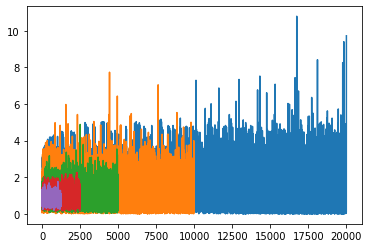

In [125]:
import matplotlib.pyplot as plt
model = TextClassifier(x_size, 16, 0, y_size).to(device)
params['batch_size'] = 1
losses = train(model, train_dataset, 1, 0.1, 2)
plt.plot(losses);
params['batch_size'] = 2
losses = train(model, train_dataset, 1, 0.1, 2)
plt.plot(losses);
params['batch_size'] = 4
losses = train(model, train_dataset, 1, 0.1, 2)
plt.plot(losses);
params['batch_size'] = 8
losses = train(model, train_dataset, 1, 0.1, 2)
plt.plot(losses);
params['batch_size'] = 16
losses = train(model, train_dataset, 1, 0.2, 2)
plt.plot(losses);

Epoch:  0 Accuracy: 0.694 Loss:0.742


Epoch:  1 Accuracy: 0.693 Loss:0.644


Epoch:  2 Accuracy: 0.702 Loss:0.563


Epoch:  3 Accuracy: 0.709 Loss:0.496


Epoch:  4 Accuracy: 0.703 Loss:0.439


Epoch:  5 Accuracy: 0.704 Loss:0.390


Epoch:  6 Accuracy: 0.716 Loss:0.347


Epoch:  7 Accuracy: 0.714 Loss:0.310


Epoch:  8 Accuracy: 0.712 Loss:0.278


Epoch:  9 Accuracy: 0.713 Loss:0.250


Epoch: 10 Accuracy: 0.712 Loss:0.227


Epoch: 11 Accuracy: 0.709 Loss:0.205


Epoch: 12 Accuracy: 0.710 Loss:0.187


Epoch: 13 Accuracy: 0.711 Loss:0.171


Epoch: 14 Accuracy: 0.706 Loss:0.156


Epoch: 15 Accuracy: 0.708 Loss:0.143


Epoch: 16 Accuracy: 0.708 Loss:0.132


Epoch: 17 Accuracy: 0.706 Loss:0.122


Epoch: 18 Accuracy: 0.710 Loss:0.113


Epoch: 19 Accuracy: 0.707 Loss:0.105


Epoch: 20 Accuracy: 0.712 Loss:0.098


Epoch: 21 Accuracy: 0.708 Loss:0.092


Epoch: 22 Accuracy: 0.704 Loss:0.087


Epoch: 23 Accuracy: 0.710 Loss:0.082


Epoch: 24 Accuracy: 0.708 Loss:0.077


Epoch: 25 Accuracy: 0.701 Loss:0.072


Epoch: 26 Accuracy: 0.709 Loss:0.069


Epoch: 27 Accuracy: 0.706 Loss:0.065


Epoch: 28 Accuracy: 0.707 Loss:0.062


Epoch: 29 Accuracy: 0.706 Loss:0.060


Epoch: 30 Accuracy: 0.703 Loss:0.057


Epoch: 31 Accuracy: 0.705 Loss:0.054


Epoch: 32 Accuracy: 0.706 Loss:0.052


Epoch: 33 Accuracy: 0.702 Loss:0.050


Epoch: 34 Accuracy: 0.704 Loss:0.048


Epoch: 35 Accuracy: 0.708 Loss:0.046


Epoch: 36 Accuracy: 0.702 Loss:0.045


Epoch: 37 Accuracy: 0.703 Loss:0.044


Epoch: 38 Accuracy: 0.704 Loss:0.042


Epoch: 39 Accuracy: 0.702 Loss:0.041


Epoch: 40 Accuracy: 0.705 Loss:0.039


Epoch: 41 Accuracy: 0.704 Loss:0.038


Epoch: 42 Accuracy: 0.704 Loss:0.037


Epoch: 43 Accuracy: 0.702 Loss:0.036


Epoch: 44 Accuracy: 0.706 Loss:0.035


Epoch: 45 Accuracy: 0.706 Loss:0.034


Epoch: 46 Accuracy: 0.704 Loss:0.033


Epoch: 47 Accuracy: 0.701 Loss:0.033


Epoch: 48 Accuracy: 0.701 Loss:0.032


Epoch: 49 Accuracy: 0.702 Loss:0.031


Epoch: 50 Accuracy: 0.703 Loss:0.030


Epoch: 51 Accuracy: 0.700 Loss:0.030


Epoch: 52 Accuracy: 0.701 Loss:0.029


Epoch: 53 Accuracy: 0.700 Loss:0.029


Epoch: 54 Accuracy: 0.702 Loss:0.028


Epoch: 55 Accuracy: 0.703 Loss:0.027


Epoch: 56 Accuracy: 0.701 Loss:0.027


Epoch: 57 Accuracy: 0.699 Loss:0.026


Epoch: 58 Accuracy: 0.701 Loss:0.026


Epoch: 59 Accuracy: 0.700 Loss:0.026


Epoch: 60 Accuracy: 0.701 Loss:0.025


Epoch: 61 Accuracy: 0.700 Loss:0.025


Epoch: 62 Accuracy: 0.703 Loss:0.025


Epoch: 63 Accuracy: 0.702 Loss:0.024


Epoch: 64 Accuracy: 0.699 Loss:0.024


Epoch: 65 Accuracy: 0.701 Loss:0.024


Epoch: 66 Accuracy: 0.703 Loss:0.023


Epoch: 67 Accuracy: 0.700 Loss:0.023


Epoch: 68 Accuracy: 0.700 Loss:0.023


Epoch: 69 Accuracy: 0.701 Loss:0.022


Epoch: 70 Accuracy: 0.702 Loss:0.022


Epoch: 71 Accuracy: 0.698 Loss:0.022


Epoch: 72 Accuracy: 0.700 Loss:0.022


Epoch: 73 Accuracy: 0.699 Loss:0.022


Epoch: 74 Accuracy: 0.700 Loss:0.021


Epoch: 75 Accuracy: 0.700 Loss:0.021


Epoch: 76 Accuracy: 0.700 Loss:0.021


Epoch: 77 Accuracy: 0.702 Loss:0.021


Epoch: 78 Accuracy: 0.700 Loss:0.021


Epoch: 79 Accuracy: 0.701 Loss:0.020


Epoch: 80 Accuracy: 0.700 Loss:0.020


Epoch: 81 Accuracy: 0.699 Loss:0.020


Epoch: 82 Accuracy: 0.700 Loss:0.020


Epoch: 83 Accuracy: 0.700 Loss:0.020


Epoch: 84 Accuracy: 0.700 Loss:0.020


Epoch: 85 Accuracy: 0.700 Loss:0.020


Epoch: 86 Accuracy: 0.700 Loss:0.019


Epoch: 87 Accuracy: 0.701 Loss:0.019


Epoch: 88 Accuracy: 0.699 Loss:0.019


Epoch: 89 Accuracy: 0.699 Loss:0.019


Epoch: 90 Accuracy: 0.699 Loss:0.019


Epoch: 91 Accuracy: 0.700 Loss:0.019


Epoch: 92 Accuracy: 0.700 Loss:0.019


Epoch: 93 Accuracy: 0.700 Loss:0.019


Epoch: 94 Accuracy: 0.700 Loss:0.019


Epoch: 95 Accuracy: 0.700 Loss:0.019


Epoch: 96 Accuracy: 0.700 Loss:0.019


Epoch: 97 Accuracy: 0.700 Loss:0.019


Epoch: 98 Accuracy: 0.700 Loss:0.019


Epoch: 99 Accuracy: 0.700 Loss:0.019



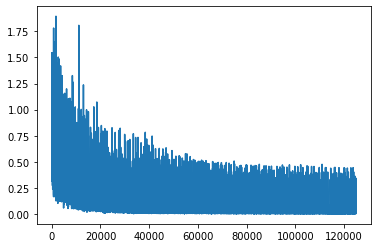

In [126]:
params['batch_size'] = 16
losses = train(model, train_dataset, 100, 0.4, 1)
plt.plot(losses);